# Ocean Health Dataset EDA

In [17]:
%run -i imports.py
v = sys.version_info
print(f"Python version {v.major}.{v.minor}.{v.micro}")
print(f"Run at {dt.datetime.now()}")

Python version 3.12.12
Run at 2026-02-08 09:17:46.294274


In [2]:
df = pd.read_csv('../data/ocean_health_index.csv')
print(df.shape)
print(df.columns)

(194, 15)
Index(['REF_AREA', 'REF_AREA_LABEL', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
      dtype='str')


In [4]:
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REF_AREA        194 non-null    str    
 1   REF_AREA_LABEL  194 non-null    str    
 2   2012            194 non-null    float64
 3   2013            194 non-null    float64
 4   2014            194 non-null    float64
 5   2015            194 non-null    float64
 6   2016            194 non-null    float64
 7   2017            194 non-null    float64
 8   2018            194 non-null    float64
 9   2019            194 non-null    float64
 10  2020            194 non-null    float64
 11  2021            194 non-null    float64
 12  2022            194 non-null    float64
 13  2023            194 non-null    float64
 14  2024            194 non-null    float64
dtypes: float64(13), str(2)
memory usage: 22.9 KB
None


In [5]:
print(df.describe())

             2012        2013        2014        2015        2016        2017  \
count  194.000000  194.000000  194.000000  194.000000  194.000000  194.000000   
mean    69.138144   69.758299   70.184742   70.746031   70.863247   70.788247   
std      5.969848    5.936358    6.010257    6.019021    6.025836    6.173841   
min     48.670000   48.780000   50.870000   51.230000   50.930000   51.110000   
25%     65.105000   65.440000   66.080000   66.992500   67.337500   67.337500   
50%     69.665000   70.135000   70.605000   71.120000   71.185000   71.200000   
75%     72.875000   73.425000   74.202500   74.872500   74.777500   74.825000   
max     82.740000   82.130000   83.060000   83.490000   83.440000   84.350000   

             2018        2019        2020        2021        2022        2023  \
count  194.000000  194.000000  194.000000  194.000000  194.000000  194.000000   
mean    70.984536   71.217320   71.448144   71.356649   71.382062   66.585361   
std      6.195274    6.1754

In [6]:
df_long = df.melt(id_vars=['REF_AREA', 'REF_AREA_LABEL'], var_name='Year')

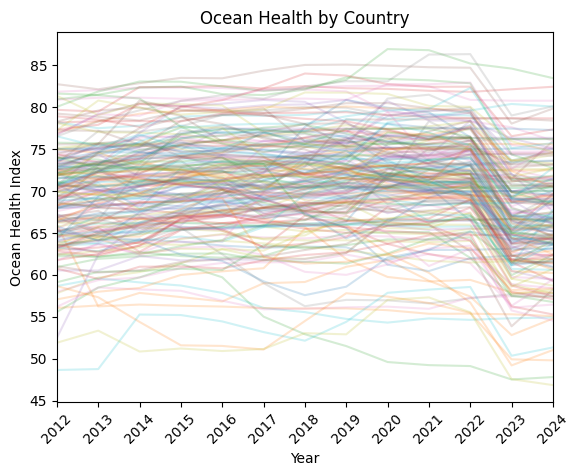

In [15]:
for country_code, df_country in df.groupby('REF_AREA'):
    plt.plot(df_country.columns[2:], df_country.iloc[0, 2:], label=df_country['REF_AREA_LABEL'].values[0], alpha=0.2)

plt.xlabel('Year') 
plt.xticks(rotation=45)
plt.ylabel('Ocean Health Index')
plt.title('Ocean Health by Country')
plt.margins(x=0)
plt.show()

In [68]:
kdes = {}
health_index_range = np.linspace(0.8*df.iloc[:,2:].min().min(),100,100)

for year in df.columns[2:]:
    kde = stats.gaussian_kde(df[year])
    kdes[year] = kde(health_index_range)

Text(0.5, 0.5, 'Ocean Health Index')

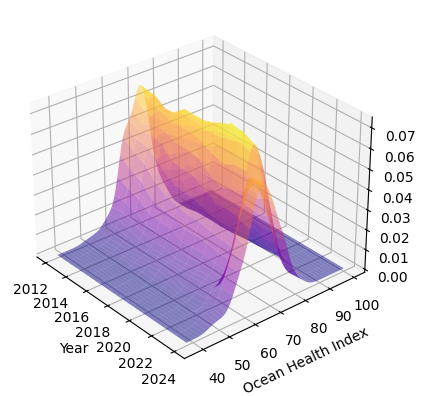

In [129]:

x = [int(i) for i in kdes.keys()]
y = health_index_range
X, Y = np.meshgrid(x, y)
Z = np.array(list(kdes.values())).T

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.5)
# for year in kdes.keys():
#     ax.plot(int(year), health_index_range, kdes[year], label=year,color='blue', alpha=0.5)
#     ax.fill_between(int(year), health_index_range, 0, int(year), health_index_range, kdes[year], color='blue', alpha=0.5)
# #ax.plot(0, health_index_range, kdes['2019'], color='blue', label='2019')
ax.view_init(elev=30, azim=320)
ax.set_xlabel('Year')
ax.set_ylabel('Ocean Health Index')

    

In [124]:
from scipy.optimize import brentq
probabilities = np.linspace(1e-5, 1-1e-5, 30)
X = np.full((len(probabilities), len(df.columns[2:])), np.nan)
Y = np.full((len(probabilities), len(df.columns[2:])), np.nan)
Z = np.full((len(probabilities), len(df.columns[2:])), np.nan)

for i, year in enumerate(df.columns[2:]):
    X[:, i] = int(year)

    # data_quantiles = np.quantile(df[year], probabilities)
    # Y[:, i] = data_quantiles

    kde = stats.gaussian_kde(df[year])


    def kde_cdf(point, kde_estimator):
        # integrate_box_1d(lower_bound, upper_bound)
        return kde_estimator.integrate_box_1d(-np.inf, point)

    # Define a target function for the root finder: CDF(x) - probability = 0
    def target_function(x, kde_estimator, probability):
        return kde_cdf(x, kde_estimator) - probability


    # 3. Use a root-finding algorithm (Brent's method) to find the quantile
    # We need to provide bounds for the search; using the min/max of the
    # original data provides good starting bounds.
    lower_bound = 0
    upper_bound = 100

    quantiles = []

    for p in probabilities:
        # print(f"year {year} probability {p}")
        # print(f"lower {target_function(lower_bound, kde, p)}")
        # print(f"upper {target_function(upper_bound, kde, p)}")
        # brentq finds the root (where target_function == 0) within the given interval [a, b]
        q_value = brentq(target_function, lower_bound , upper_bound, args=(kde, p))
        quantiles.append(q_value)

    Y[:, i] = quantiles
    #Z[:, i] = probabilities
    Z[:, i] = kde(quantiles)

In [125]:
Xx, Yy = np.meshgrid([0,2], [1,3,5])
print(Xx)
print(Yy)

[[0 2]
 [0 2]
 [0 2]]
[[1 1]
 [3 3]
 [5 5]]


Text(0.5, 0.5, 'Ocean Health Index')

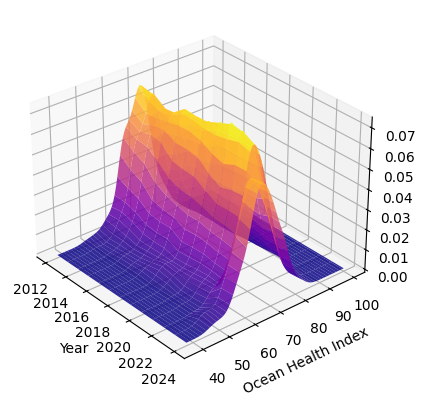

In [130]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.85)
ax.view_init(elev=30, azim=320)
ax.set_xlabel('Year')
ax.set_ylabel('Ocean Health Index')


In [111]:
np.linspace(1e-2, 1-1e-2, 30)

array([0.01      , 0.0437931 , 0.07758621, 0.11137931, 0.14517241,
       0.17896552, 0.21275862, 0.24655172, 0.28034483, 0.31413793,
       0.34793103, 0.38172414, 0.41551724, 0.44931034, 0.48310345,
       0.51689655, 0.55068966, 0.58448276, 0.61827586, 0.65206897,
       0.68586207, 0.71965517, 0.75344828, 0.78724138, 0.82103448,
       0.85482759, 0.88862069, 0.92241379, 0.9562069 , 0.99      ])

Open questions:

* Group: what happened in 2022, either to negatively affect ocean health across the board or to redefine the metric itself?
* Individual: most improved/regressed? 
* can we group these?
* bring in exogeneous variables?